In [1]:
import pandas as pd
import numpy as np
import itertools as it

import pickle as pcl

from scipy.spatial.distance import cdist

import math

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

from palettable.tableau import GreenOrange_12
cmap = GreenOrange_12.hex_colors

from collections import Counter

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import MeanShift

In [2]:
import hightolowz

from protocluster_completeness_purity import cluster_stats

In [3]:
L = 480.279

## Data

In [4]:
gals = pd.read_csv('data/z0_virial.csv', skiprows=57, skipfooter=1)

/home/chris/anaconda/envs/cosmo/lib/python2.7/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


In [5]:
gals_z11p51_sfr = pd.read_csv('data/r200/henriques2015a_z11p51_sfr_r200.csv', skiprows=107, skipfooter=1, engine='python')
gals_z10p57_sfr = pd.read_csv('data/r200/henriques2015a_z10p57_sfr_r200.csv', skiprows=107, skipfooter=1, engine='python')
gals_z9p72_sfr = pd.read_csv('data/r200/henriques2015a_z9p72_sfr_r200.csv', skiprows=107, skipfooter=1, engine='python')
gals_z8p93_sfr = pd.read_csv('data/r200/henriques2015a_z8p93_sfr_r200.csv', skiprows=107, skipfooter=1, engine='python')
gals_z7p57_sfr = pd.read_csv('data/r200/henriques2015a_z7p57_sfr_r200.csv', skiprows=107, skipfooter=1, engine='python')

In [6]:
gals_z6p42_sfr = pd.read_csv('data/r200/henriques2015a_z6p42_sfr_r200.csv', skiprows=107, skipfooter=1, engine='python')
gals_z5p03_sfr = pd.read_csv('data/r200/henriques2015a_z5p03_sfr_r200.csv', skiprows=107, skipfooter=1, engine='python')
gals_z3p95_sfr = pd.read_csv('data/r200/henriques2015a_z3p95_sfr_r200.csv', skiprows=107, skipfooter=1, engine='python')
gals_z3p10_sfr = pd.read_csv('data/r200/henriques2015a_z3p10_sfr_r200.csv', skiprows=107, skipfooter=1, engine='python')
gals_z2p07_sfr = pd.read_csv('data/r200/henriques2015a_z2p07_sfr_r200.csv', skiprows=107, skipfooter=1, engine='python')

In [7]:
gals_z11p51_mstar = pd.read_csv('data/r200/henriques2015a_z11p51_mstar_r200.csv', skiprows=107, skipfooter=1, engine='python')
gals_z10p57_mstar = pd.read_csv('data/r200/henriques2015a_z10p57_mstar_r200.csv', skiprows=107, skipfooter=1, engine='python')
gals_z9p72_mstar = pd.read_csv('data/r200/henriques2015a_z9p72_mstar_r200.csv', skiprows=107, skipfooter=1, engine='python')
gals_z8p93_mstar = pd.read_csv('data/r200/henriques2015a_z8p93_mstar_r200.csv', skiprows=107, skipfooter=1, engine='python')
gals_z7p57_mstar = pd.read_csv('data/r200/henriques2015a_z7p57_mstar_r200.csv', skiprows=107, skipfooter=1, engine='python')

In [8]:
gals_z6p42_mstar = pd.read_csv('data/r200/henriques2015a_z6p42_mstar_r200.csv', skiprows=107, skipfooter=1, engine='python')
gals_z5p03_mstar = pd.read_csv('data/r200/henriques2015a_z5p03_mstar_r200.csv', skiprows=107, skipfooter=1, engine='python')
gals_z3p95_mstar = pd.read_csv('data/r200/henriques2015a_z3p95_mstar_r200.csv', skiprows=107, skipfooter=1, engine='python')
gals_z3p10_mstar = pd.read_csv('data/r200/henriques2015a_z3p10_mstar_r200.csv', skiprows=107, skipfooter=1, engine='python')
gals_z2p07_mstar = pd.read_csv('data/r200/henriques2015a_z2p07_mstar_r200.csv', skiprows=107, skipfooter=1, engine='python')

### z0

In [117]:
def z0_eigs(gals):

    eig_values = []

    for cluster in pd.unique(gals['cen_haloId']):

        coods = gals[gals['cen_haloId'] == cluster][['hen_x','hen_y','hen_z']].copy()

        if np.abs(coods['hen_x'].max() - coods['hen_x'].min()) > L/2:
            coods['hen_x'] = coods['hen_z'] - L
            coods['hen_x'].loc[coods['hena_z'] < -L/2] = gals[gals['cen_haloId'] == cluster]['hen_x'][coods['hen_x'] < -L/2]

        if np.abs(coods['hen_y'].max() - coods['hen_y'].min()) > L/2:
            coods['hen_y'] = coods['hen_z'] - L
            coods['hen_y'].loc[coods['hen_z'] < -L/2] = gals[gals['cen_haloId'] == cluster]['hen_y'][coods['hen_y'] < -L/2]

        if np.abs(coods['hen_z'].max() - coods['hen_z'].min()) > L/2:
            coods['hen_z'] = coods['hen_z'] - L
            coods['hen_z'].loc[coods['hen_z'] < -L/2] = gals[gals['fofSubHaloId'] == cluster]['hen_z'][coods['hen_z'] < -L/2]

        center = np.mean(coods)
        coods = coods - center

        I = np.zeros((3, 3))

        I[0,0] = np.sum(coods['hen_z']**2 + coods['hen_y']**2)
        I[1,1] = np.sum(coods['hen_z']**2 + coods['hen_x']**2)
        I[2,2] = np.sum(coods['hen_x']**2 + coods['hen_y']**2)

        I[0,1] = I[1,0] = - np.sum(coods['hen_x'] * coods['hen_y'])
        I[1,2] = I[2,1] = - np.sum(coods['hen_z'] * coods['hen_y'])
        I[0,2] = I[2,0] = - np.sum(coods['hen_z'] * coods['hen_x'])

        e_values, e_vectors = np.linalg.eig(I)

        eig_values.append(np.sort(e_values))


    return np.array(eig_values)

In [118]:
# eig_values = [None] * 3

eig_values = z0_eigs(gals)

# eig_values[2] = eig_values[2][~(eig_values[2][:,0] == 0.),:]

NameError: name 'linestyle' is not defined

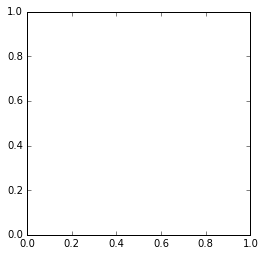

In [25]:
fig, ax = plt.subplots(figsize=(4,4))

binLimits = np.linspace(0, 1, 21)
bins = np.linspace(0.025, 0.975, 20)

## z0 shapes

phi, dummy = np.histogram(eig_values[:,0] / eig_values[:,2], bins=binLimits, normed=True)
ax.step(bins, phi, c='red', linestyle=linestyle)

phi, dummy = np.histogram(eig_values[:,1] / eig_values[:,2], bins=binLimits, normed=True)
ax.step(bins, phi, c='blue', linestyle=linestyle)

ax.vlines(0.5, 0, 6, linestyles='dotted', color='grey')

# plt.savefig('../papers/hightolowz/images/ax_ratios.png', bbox_inches='tight', dpi=300)

[ 10.91784285  18.25719338  21.14659477] 34783.082
0.51629318917 0.863363278193


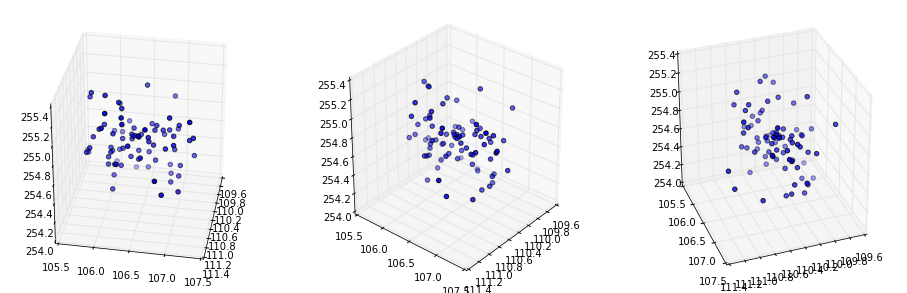

In [12]:
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

idx = 1030

ax1.scatter(gals[gals['cen_haloId'] == pd.unique(gals['cen_haloId'])[idx]]['hen_x'],
           gals[gals['cen_haloId'] == pd.unique(gals['cen_haloId'])[idx]]['hen_y'],
           zs=gals[gals['cen_haloId'] == pd.unique(gals['cen_haloId'])[idx]]['hen_z'])

ax2.scatter(gals[gals['cen_haloId'] == pd.unique(gals['cen_haloId'])[idx]]['hen_x'],
           gals[gals['cen_haloId'] == pd.unique(gals['cen_haloId'])[idx]]['hen_y'],
           zs=gals[gals['cen_haloId'] == pd.unique(gals['cen_haloId'])[idx]]['hen_z'])

ax3.scatter(gals[gals['cen_haloId'] == pd.unique(gals['cen_haloId'])[idx]]['hen_x'],
           gals[gals['cen_haloId'] == pd.unique(gals['cen_haloId'])[idx]]['hen_y'],
           zs=gals[gals['cen_haloId'] == pd.unique(gals['cen_haloId'])[idx]]['hen_z'])

ax1.view_init(30, 10)
ax2.view_init(30, 40)
ax3.view_init(30, 70)

print eigs[idx,:], pd.unique(gals['cen_m_crit200'])[idx]
print eigs[idx,0] / eigs[idx,2], eigs[idx,1] / eigs[idx,2]

# cols = ['r','b','g']

# for j in range(len(e_vectors)):
#     print e_vectors[j]
    
#     e_components = e_vectors[j] * e_values[j] / 150

#     ax.plot([0, e_components[0]], 
#              [0, e_components[1]], 
#              [0, e_components[2]], c=cols[j])


## Shapes

In [113]:
def calc_eigs_inertia(gals):

    eig_values = []
    unresolved = 0

    for cluster in np.unique(gals[gals['z0_central_mcrit200'] > 1e4]['z0_centralId']):
        
        if np.sum(gals['z0_centralId'] == cluster) < 4:
            unresolved += 1
            
        else:
            coods = gals[gals['z0_centralId'] == cluster][['zn_x','zn_y','zn_z']].copy()

            if np.abs(coods['zn_x'].max() - coods['zn_x'].min()) > L/2:
                coods['zn_x'] = coods['zn_x'] - L
                coods['zn_x'].loc[coods['zn_x'] < -L/2] = gals[gals['z0_centralId'] == cluster]['zn_x'][coods['zn_x'] < -L/2]

            if np.abs(coods['zn_y'].max() - coods['zn_y'].min()) > L/2:
                coods['zn_y'] = coods['zn_y'] - L
                coods['zn_y'].loc[coods['zn_y'] < -L/2] = gals[gals['z0_centralId'] == cluster]['zn_y'][coods['zn_y'] < -L/2]

            if np.abs(coods['zn_z'].max() - coods['zn_z'].min()) > L/2:
                coods['zn_z'] = coods['zn_z'] - L
                coods['zn_z'].loc[coods['zn_z'] < -L/2] = gals[gals['z0_centralId'] == cluster]['zn_z'][coods['zn_z'] < -L/2]

            center = np.mean(coods)
            coods = coods - center
            
            I = np.zeros((3, 3))

            I[0,0] = np.sum(coods['zn_z']**2 + coods['zn_y']**2)
            I[1,1] = np.sum(coods['zn_z']**2 + coods['zn_x']**2)
            I[2,2] = np.sum(coods['zn_x']**2 + coods['zn_y']**2)

            I[0,1] = I[1,0] = - np.sum(coods['zn_x'] * coods['zn_y'])
            I[1,2] = I[2,1] = - np.sum(coods['zn_z'] * coods['zn_y'])
            I[0,2] = I[2,0] = - np.sum(coods['zn_z'] * coods['zn_x'])

            e_values, e_vectors = np.linalg.eig(I)
            
            eig_values.append(np.sort(e_values))    
        
        
    return np.array(eig_values), unresolved

In [114]:
# eig_vals_z6p42_mstar9, unresolved_z6p42 = calc_eigs_inertia(gals_z6p42_mstar)
# eig_vals_z5p03_mstar9, unresolved_z5p03 = calc_eigs_inertia(gals_z5p03_mstar)
# eig_vals_z3p95_mstar9, unresolved_z3p95 = calc_eigs_inertia(gals_z3p95_mstar)
# eig_vals_z3p10_mstar9, unresolved_z3p10 = calc_eigs_inertia(gals_z3p10_mstar)
# eig_vals_z2p07_mstar9, unresolved_z2p07 = calc_eigs_inertia(gals_z2p07_mstar)
eig_vals_z11p51_mstar9, unresolved = calc_eigs_inertia(gals_z11p51_mstar)
eig_vals_z10p57_mstar9, unresolved = calc_eigs_inertia(gals_z10p57_mstar)
eig_vals_z9p72_mstar9, unresolved = calc_eigs_inertia(gals_z9p72_mstar)
eig_vals_z8p93_mstar9, unresolved = calc_eigs_inertia(gals_z8p93_mstar)
eig_vals_z7p57_mstar9, unresolved = calc_eigs_inertia(gals_z7p57_mstar)

# eig_vals_z6p42_sfr, unresolved_z6p42 = calc_eigs_inertia(gals_z6p42_sfr)
# eig_vals_z5p03_sfr, unresolved_z5p03 = calc_eigs_inertia(gals_z5p03_sfr)
# eig_vals_z3p95_sfr, unresolved_z3p95 = calc_eigs_inertia(gals_z3p95_sfr)
# eig_vals_z3p10_sfr, unresolved_z3p10 = calc_eigs_inertia(gals_z3p10_sfr)
# eig_vals_z2p07_sfr, unresolved_z2p07 = calc_eigs_inertia(gals_z2p07_sfr)
eig_vals_z11p51_sfr, unresolved = calc_eigs_inertia(gals_z11p51_sfr)
eig_vals_z10p57_sfr, unresolved = calc_eigs_inertia(gals_z10p57_sfr)
eig_vals_z9p72_sfr, unresolved = calc_eigs_inertia(gals_z9p72_sfr)
eig_vals_z8p93_sfr, unresolved = calc_eigs_inertia(gals_z8p93_sfr)
eig_vals_z7p57_sfr, unresolved = calc_eigs_inertia(gals_z7p57_sfr)

# eig_vals_z6p42_mstar10, unresolved_z6p42 = calc_eigs_inertia(gals_z6p42_mstar.loc[gals_z6p42_mstar['zn_stellarMass'] > 1])
# eig_vals_z5p03_mstar10, unresolved_z5p03 = calc_eigs_inertia(gals_z5p03_mstar.loc[gals_z5p03_mstar['zn_stellarMass'] > 1])
# eig_vals_z3p95_mstar10, unresolved_z3p95 = calc_eigs_inertia(gals_z3p95_mstar.loc[gals_z3p95_mstar['zn_stellarMass'] > 1])
# eig_vals_z3p10_mstar10, unresolved_z3p10 = calc_eigs_inertia(gals_z3p10_mstar.loc[gals_z3p10_mstar['zn_stellarMass'] > 1])
# eig_vals_z2p07_mstar10, unresolved_z2p07 = calc_eigs_inertia(gals_z2p07_mstar.loc[gals_z2p07_mstar['zn_stellarMass'] > 1])

pcl.dump([eig_vals_z11p51_mstar9,eig_vals_z10p57_mstar9,eig_vals_z9p72_mstar9,eig_vals_z8p93_mstar9,eig_vals_z7p57_mstar9,
          eig_vals_z6p42_mstar9,eig_vals_z5p03_mstar9,eig_vals_z3p95_mstar9,eig_vals_z3p10_mstar9,eig_vals_z2p07_mstar9,
          eig_vals_z6p42_sfr,eig_vals_z5p03_sfr,eig_vals_z3p95_sfr,eig_vals_z3p10_sfr,eig_vals_z2p07_sfr,
          eig_vals_z7p57_sfr,eig_vals_z8p93_sfr,eig_vals_z9p72_sfr,eig_vals_z10p57_sfr,eig_vals_z11p51_sfr,
          eig_vals_z6p42_mstar10,eig_vals_z5p03_mstar10,eig_vals_z3p95_mstar10,eig_vals_z3p10_mstar10,eig_vals_z2p07_mstar10], 
          open('data/eigs_r200.p','wb'))

In [115]:
eigs = pcl.load(open('data/eigs_r200.p', 'rb'))

eig_vals_z2p07_sfr = eigs[14]
eig_vals_z3p10_sfr = eigs[13]
eig_vals_z3p95_sfr = eigs[12]
eig_vals_z5p03_sfr = eigs[11]
eig_vals_z6p42_sfr = eigs[10]
eig_vals_z7p57_sfr = eigs[19]
eig_vals_z8p93_sfr = eigs[18]
eig_vals_z9p72_sfr = eigs[17]
eig_vals_z10p57_sfr = eigs[16]
eig_vals_z11p51_sfr = eigs[15]

eig_vals_z2p07_mstar9 = eigs[9]
eig_vals_z3p10_mstar9 = eigs[8]
eig_vals_z3p95_mstar9 = eigs[7]
eig_vals_z5p03_mstar9 = eigs[6]
eig_vals_z6p42_mstar9 = eigs[5]
eig_vals_z7p57_mstar9 = eigs[4]
eig_vals_z8p93_mstar9 = eigs[3]
eig_vals_z9p72_mstar9 = eigs[2]
eig_vals_z10p57_mstar9 = eigs[1]
eig_vals_z11p51_mstar9 = eigs[0]

eig_vals_z2p07_mstar10 = eigs[24]
eig_vals_z3p10_mstar10 = eigs[23]
eig_vals_z3p95_mstar10 = eigs[22]
eig_vals_z5p03_mstar10 = eigs[21]
eig_vals_z6p42_mstar10 = eigs[20]

del eigs

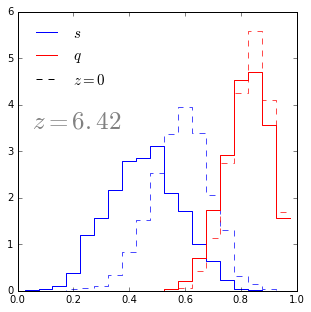

In [120]:
fig = plt.figure(figsize=(5,5))

c1 = 'blue'
c2 = 'red'

phi, dummy = np.histogram(eig_values[:,0] / eig_values[:,2], bins=binLimits, normed=True)
plt.step(bins, phi, c='blue', linestyle='dashed', alpha=0.7)

phi, dummy = np.histogram(eig_values[:,1] / eig_values[:,2], bins=binLimits, normed=True)
plt.step(bins, phi, c='red', linestyle='dashed', alpha=0.7)

phi, dummy = np.histogram(eig_vals_z6p42_sfr[:,0] / eig_vals_z6p42_sfr[:,2], bins=binLimits, normed=True)
plt.step(bins,phi, color='blue', linestyle='solid')

phi, dummy = np.histogram(eig_vals_z6p42_sfr[:,1] / eig_vals_z6p42_sfr[:,2], bins=binLimits, normed=True)
plt.step(bins,phi, color='red', linestyle='solid')

sArtist = plt.Line2D((0,1),(0,0), color=c1)
qArtist = plt.Line2D((0,1),(0,0), color=c2)

z0Artist = plt.Line2D((0,1),(0,0), color='black', linestyle='dashed')

plt.legend(handles=[sArtist,qArtist,z0Artist], labels=['$s$','$q$','$z=0$'], loc=2, frameon=False, prop={'size':15})

plt.text(0.05, 3.5, '$z = 6.42$', size=25, color='grey')

# plt.savefig('../papers/hightolowz/images/ax_ratios_single.png', bbox_inches='tight', dpi=300)

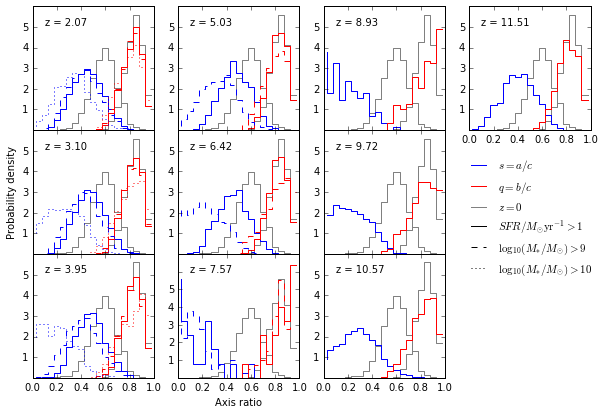

In [138]:
fig = plt.figure(figsize=(10,12))

gs = gridspec.GridSpec(3, 4)

gs.update(bottom = 0.57, top = 1, hspace=0) #, wspace=0)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[2,0])

ax4 = fig.add_subplot(gs[0,1])
ax5 = fig.add_subplot(gs[1,1])
ax6 = fig.add_subplot(gs[2,1])

ax7 = fig.add_subplot(gs[0,2])
ax8 = fig.add_subplot(gs[1,2])
ax9 = fig.add_subplot(gs[2,2])

ax10 = fig.add_subplot(gs[0,3])


binLimits = np.linspace(0, 1, 21)
bins = np.linspace(0.025, 0.975, 20)

ls = ['solid','dashed','dotted']
#linestyle='solid'

## z0 shapes

# for linestyle, eigs in zip(ls, eig_values):
for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]:

    phi, dummy = np.histogram(eig_values[:,0] / eig_values[:,2], bins=binLimits, normed=True)
    ax.step(bins, phi, c='grey', linestyle='solid')

    phi, dummy = np.histogram(eig_values[:,1] / eig_values[:,2], bins=binLimits, normed=True)
    ax.step(bins, phi, c='grey', linestyle='solid')



c1 = 'blue'
c2 = 'red'

for i, eigs in enumerate([eig_vals_z2p07_sfr, eig_vals_z2p07_mstar9, eig_vals_z2p07_mstar10]):
    phi, dummy = np.histogram(eigs[:,0] / eigs[:,2], bins=binLimits, normed=True)
    ax1.step(bins,phi, color=c1, linestyle=ls[i])

    phi, dummy = np.histogram(eigs[:,1] / eigs[:,2], bins=binLimits, normed=True)
    ax1.step(bins,phi, color=c2, linestyle=ls[i])
    
    
for i, eigs in enumerate([eig_vals_z3p10_sfr, eig_vals_z3p10_mstar9, eig_vals_z3p10_mstar10]):
    phi, dummy = np.histogram(eigs[:,0] / eigs[:,2], bins=binLimits, normed=True)
    ax2.step(bins,phi, color=c1, linestyle=ls[i])

    phi, dummy = np.histogram(eigs[:,1] / eigs[:,2], bins=binLimits, normed=True)
    ax2.step(bins,phi, color=c2, linestyle=ls[i])


for i, eigs in enumerate([eig_vals_z3p95_sfr, eig_vals_z3p95_mstar9, eig_vals_z3p95_mstar10]):
    phi, dummy = np.histogram(eigs[:,0] / eigs[:,2], bins=binLimits, normed=True)
    ax3.step(bins,phi, color=c1, linestyle=ls[i])

    phi, dummy = np.histogram(eigs[:,1] / eigs[:,2], bins=binLimits, normed=True)
    ax3.step(bins,phi, color=c2, linestyle=ls[i])
    
    
for i, eigs in enumerate([eig_vals_z5p03_sfr, eig_vals_z5p03_mstar9]): # , eig_vals_z3p95_mstar10]):
    phi, dummy = np.histogram(eigs[:,0] / eigs[:,2], bins=binLimits, normed=True)
    ax4.step(bins,phi, color=c1, linestyle=ls[i])

    phi, dummy = np.histogram(eigs[:,1] / eigs[:,2], bins=binLimits, normed=True)
    ax4.step(bins,phi, color=c2, linestyle=ls[i])


for i, eigs in enumerate([eig_vals_z6p42_sfr, eig_vals_z6p42_mstar9]): # , eig_vals_z3p95_mstar10]):
    phi, dummy = np.histogram(eigs[:,0] / eigs[:,2], bins=binLimits, normed=True)
    ax5.step(bins,phi, color=c1, linestyle=ls[i])

    phi, dummy = np.histogram(eigs[:,1] / eigs[:,2], bins=binLimits, normed=True)
    ax5.step(bins,phi, color=c2, linestyle=ls[i])
    
    
for i, eigs in enumerate([eig_vals_z7p57_sfr, eig_vals_z7p57_mstar9]): # , eig_vals_z3p95_mstar10]):
    phi, dummy = np.histogram(eigs[:,0] / eigs[:,2], bins=binLimits, normed=True)
    ax6.step(bins,phi, color=c1, linestyle=ls[i])

    phi, dummy = np.histogram(eigs[:,1] / eigs[:,2], bins=binLimits, normed=True)
    ax6.step(bins,phi, color=c2, linestyle=ls[i])
    
    
for i, eigs in enumerate([eig_vals_z8p93_sfr]): #, eig_vals_z8p93_mstar9]): #, eig_vals_z5p03_mstar10]):
    phi, dummy = np.histogram(eigs[:,0] / eigs[:,2], bins=binLimits, normed=True)
    ax7.step(bins,phi, color=c1, linestyle=ls[i])

    phi, dummy = np.histogram(eigs[:,1] / eigs[:,2], bins=binLimits, normed=True)
    ax7.step(bins,phi, color=c2, linestyle=ls[i])


for i, eigs in enumerate([eig_vals_z9p72_sfr]): #, eig_vals_z8p93_mstar9]): #, eig_vals_z5p03_mstar10]):
    phi, dummy = np.histogram(eigs[:,0] / eigs[:,2], bins=binLimits, normed=True)
    ax8.step(bins,phi, color=c1, linestyle=ls[i])

    phi, dummy = np.histogram(eigs[:,1] / eigs[:,2], bins=binLimits, normed=True)
    ax8.step(bins,phi, color=c2, linestyle=ls[i])


for i, eigs in enumerate([eig_vals_z10p57_sfr]): #, eig_vals_z10p57_mstar9]): #, eig_vals_z6p42_mstar10]):
    phi, dummy = np.histogram(eigs[:,0] / eigs[:,2], bins=binLimits, normed=True)
    ax9.step(bins,phi, color=c1, linestyle=ls[i])

    phi, dummy = np.histogram(eigs[:,1] / eigs[:,2], bins=binLimits, normed=True)
    ax9.step(bins,phi, color=c2, linestyle=ls[i])
    
    
for i, eigs in enumerate([eig_vals_z11p51_sfr]): #, eig_vals_z10p57_mstar9]): #, eig_vals_z6p42_mstar10]):
    phi, dummy = np.histogram(eigs[:,0] / eigs[:,2], bins=binLimits, normed=True)
    ax10.step(bins,phi, color=c1, linestyle=ls[i])

    phi, dummy = np.histogram(eigs[:,1] / eigs[:,2], bins=binLimits, normed=True)
    ax10.step(bins,phi, color=c2, linestyle=ls[i])



ax1.text(0.1, 0.85, "z = 2.07", transform = ax1.transAxes)
ax2.text(0.1, 0.85, "z = 3.10", transform = ax2.transAxes)
ax3.text(0.1, 0.85, "z = 3.95", transform = ax3.transAxes)
ax4.text(0.1, 0.85, "z = 5.03", transform = ax4.transAxes)
ax5.text(0.1, 0.85, "z = 6.42", transform = ax5.transAxes)

ax6.text(0.1, 0.85, "z = 7.57", transform = ax6.transAxes)
ax7.text(0.1, 0.85, "z = 8.93", transform = ax7.transAxes)
ax8.text(0.1, 0.85, "z = 9.72", transform = ax8.transAxes)
ax9.text(0.1, 0.85, "z = 10.57", transform = ax9.transAxes)
ax10.text(0.1, 0.85, "z = 11.51", transform = ax10.transAxes)

## Legend

sArtist = plt.Line2D((0,1),(0,0), color=c1)
qArtist = plt.Line2D((0,1),(0,0), color=c2)
Artist0 = plt.Line2D((0,1),(0,0), color='grey')

sfrArtist = plt.Line2D((0,1),(0,0), color='black', linestyle='solid')
mstar9Artist = plt.Line2D((0,1),(0,0), color='black', linestyle='dashed')
mstar10Artist = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted')

ax10.legend(handles=[sArtist, qArtist, Artist0, sfrArtist, mstar9Artist, mstar10Artist], 
           labels=['$s = a / c$','$q = b / c$','$z=0$',
                   '$SFR / M_{\odot} \mathrm{yr}^{-1} > 1$',
                   '$\mathrm{log_{10}}(M_{*} / M_{\odot}) > 9$',
                  '$\mathrm{log_{10}}(M_{*} / M_{\odot}) > 10$'], 
           bbox_to_anchor=(1.1, -0.14), prop={'size':11}, frameon=False)

for ax in [ax1, ax2, ax4, ax5, ax7, ax8]:
    ax.set_xticklabels([])

for ax in [ax1,ax2,ax3,ax4,ax5, ax6, ax7, ax8, ax9, ax10]:
    ax.set_yticklabels(['','1','2','3','4','5'])
    
ax6.set_xlabel('Axis ratio')
ax2.set_ylabel('Probability density')

# plt.savefig('../papers/hightolowz/images/ax_ratios.png', bbox_inches='tight', dpi=300)

IndexError: too many indices for array

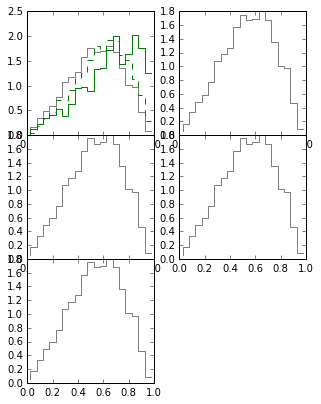

In [33]:
fig = plt.figure(figsize=(5,12))

gs = gridspec.GridSpec(3, 2)

gs.update(bottom = 0.57, top = 1, hspace=0) #, wspace=0)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[2,0])

ax4 = fig.add_subplot(gs[0,1])
ax5 = fig.add_subplot(gs[1,1])

binLimits = np.linspace(0, 1, 21)
bins = np.linspace(0.025, 0.975, 20)

for ax in [ax1, ax2, ax3, ax4, ax5]:

    phi, dummy = np.histogram( (eig_values[:,0]**2 - eig_values[:,1]**2) \
                              / (eig_values[:,0]**2 - eig_values[:,2]**2), bins=binLimits, normed=True)
    ax.step(bins, phi, c='grey')


## Plot 1

ls = ['solid','dashed','dotted']

c1 = 'green'

for i, eigs in enumerate([eig_vals_z2p07_sfr, eig_vals_z2p07_mstar9, eig_vals_z2p07_mstar10]):
    phi, dummy = np.histogram((eigs[:,0]**2 - eigs[:,1]**2) / (eigs[:,0]**2 - eigs[:,2]**2), bins=binLimits, normed=True)
    ax1.step(bins,phi, color=c1, linestyle=ls[i])


# ax1.set_ylim(0, 5)

## Plot 2

for i, eigs in enumerate([eig_vals_z3p10_sfr, eig_vals_z3p10_mstar9, eig_vals_z3p10_mstar10]):
    phi, dummy = np.histogram((eigs[:,0]**2 - eigs[:,1]**2) / (eigs[:,0]**2 - eigs[:,2]**2), bins=binLimits, normed=True)
    ax2.step(bins,phi, color=c1, linestyle=ls[i])

# ax2.set_ylim(0, 5)

## Plot 3

for i, eigs in enumerate([eig_vals_z3p95_sfr, eig_vals_z3p95_mstar9, eig_vals_z3p95_mstar10]):
    phi, dummy = np.histogram((eigs[:,0]**2 - eigs[:,1]**2) / (eigs[:,0]**2 - eigs[:,2]**2), bins=binLimits, normed=True)
    ax3.step(bins,phi, color=c1, linestyle=ls[i])

# ax3.set_ylim(0, 5)

for i, eigs in enumerate([eig_vals_z5p03_sfr, eig_vals_z5p03_mstar9]): #, eig_vals_z5p03_mstar10]):
    phi, dummy = np.histogram((eigs[:,0]**2 - eigs[:,1]**2) / (eigs[:,0]**2 - eigs[:,2]**2), bins=binLimits, normed=True)
    ax4.step(bins,phi, color=c1, linestyle=ls[i])

# ax4.set_ylim(0, 5)

for i, eigs in enumerate([eig_vals_z6p42_sfr, eig_vals_z6p42_mstar9]): #, eig_vals_z6p42_mstar10]):
    phi, dummy = np.histogram((eigs[:,0]**2 - eigs[:,1]**2) / (eigs[:,0]**2 - eigs[:,2]**2), bins=binLimits, normed=True)
    ax5.step(bins,phi, color=c1, linestyle=ls[i])
    

# ax5.set_ylim(0, 5)

ax1.text(0.1, 0.85, "z = 2.07", transform = ax1.transAxes)
ax2.text(0.1, 0.85, "z = 3.10", transform = ax2.transAxes)
ax3.text(0.1, 0.85, "z = 3.95", transform = ax3.transAxes)
ax4.text(0.1, 0.85, "z = 5.03", transform = ax4.transAxes)
ax5.text(0.1, 0.85, "z = 6.42", transform = ax5.transAxes)

for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.vlines(1./3, 0, 3, linestyles='dotted', colors='grey')
    ax.vlines(2./3, 0, 3, linestyles='dotted', colors='grey')

## Legend

tArtist = plt.Line2D((0,1),(0,0), color=c1)

sfrArtist = plt.Line2D((0,1),(0,0), color='black', linestyle='solid')
mstar9Artist = plt.Line2D((0,1),(0,0), color='black', linestyle='dashed')
mstar10Artist = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted')

ax5.legend(handles=[tArtist, sfrArtist, mstar9Artist, mstar10Artist], 
           labels=['T','$SFR / M_{\odot} \mathrm{yr}^{-1} > 1$',
                   '$\mathrm{log_{9}}(M_{*} / M_{\odot}) > 9$',
                  '$\mathrm{log_{10}}(M_{*} / M_{\odot}) > 10$'], 
           bbox_to_anchor=(1.1, -0.14), prop={'size':11}, frameon=False)

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax4.set_xticklabels([])

for ax in [ax1,ax2,ax3,ax4,ax5]:
    ax.set_yticklabels(['','0.5','1.0','1.5','2.0','2.5',''])
    
ax3.set_xlabel('T')
ax2.set_ylabel('Probability density')

# plt.savefig('../papers/hightolowz/images/triax_param.png', bbox_inches='tight', dpi=300)

## Mass Function

[  6.8   7.2   7.6   8.    8.4   8.8   9.2   9.6  10.   10.4  10.8  11.2
  11.6  12.   12.4  12.8] [  7.    7.4   7.8   8.2   8.6   9.    9.4   9.8  10.2  10.6  11.   11.4
  11.8  12.2  12.6]


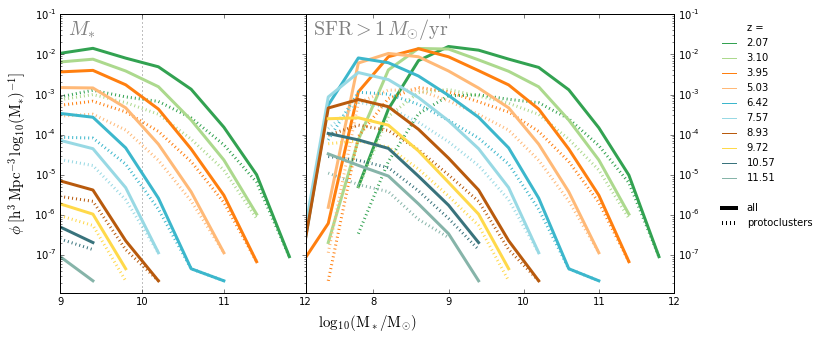

In [14]:
binLimits = np.linspace(6.8, 12.8, 16)
bins = np.linspace(7, 12.6, 15)

print binLimits, bins

fig = plt.figure(figsize=(11,5))

gs = gridspec.GridSpec(1,10)

gs.update(wspace=0) # bottom = 0.57, top = 1, hspace=0, 

ax1 = fig.add_subplot(gs[0,0:4])
ax2 = fig.add_subplot(gs[0,4:10])

galaxy_mstar = [gals_z2p07_mstar, gals_z3p10_mstar, gals_z3p95_mstar, gals_z5p03_mstar, gals_z6p42_mstar,
                gals_z7p57_mstar, gals_z8p93_mstar, gals_z9p72_mstar, gals_z10p57_mstar, gals_z11p51_mstar]

galaxy_sfr = [gals_z2p07_sfr, gals_z3p10_sfr, gals_z3p95_sfr, gals_z5p03_sfr, gals_z6p42_sfr,
              gals_z7p57_sfr, gals_z8p93_sfr, gals_z9p72_sfr, gals_z10p57_sfr, gals_z11p51_sfr]

zees = ['2.07','3.10','3.95','5.03','6.42','7.57','8.93','9.72','10.57','11.51']

for ax, galaxy in zip([ax1, ax2],[galaxy_mstar, galaxy_sfr]):

    for i, (gals,z) in enumerate(zip(galaxy, zees)):

        phi, dummy = np.histogram(np.log10(gals['zn_stellarMass'] * 1e10), bins=binLimits)
        phi = (phi / L**3) / (binLimits[1] - binLimits[0])

        ax.semilogy(bins, phi, c=cmap[i], label=z, linestyle='solid', linewidth=3)

        phi, dummy = np.histogram(np.log10(gals.loc[gals['z0_central_mcrit200'] > 1e4]['zn_stellarMass'] * 1e10), bins=binLimits)
        phi = (phi / L**3) / (binLimits[1] - binLimits[0])

        ax.semilogy(bins, phi, c=cmap[i], linestyle='dotted', linewidth=3)



ax1.text(1.05, -0.12, "$\\rm{log_{10}}(M_* / M_{\odot})$", size=15, transform = ax1.transAxes)
ax1.set_ylabel("$\phi \; [\\mathrm{h^{3} \, Mpc^{-3} \, log_{10}(M_{*})^{-1}}]$", size=15)

ax1.set_xticks([9, 10, 11, 12])

ax1.set_xlim(9, 12)
ax2.set_xlim(7.1, 12)

ax1.set_ylim(1.1e-8, 1e-1)
ax2.set_ylim(1.1e-8, 1e-1)

ax2.yaxis.tick_right()

ax1.vlines(10, 1e-9, 1e-1, linestyle='dotted', color='grey')
ax1.vlines(9, 1e-9, 1e-1, linestyle='dotted', color='grey')

ax1.text(9.1, 3e-2, '$M_{*}$', color='grey', size=20)
ax2.text(7.2, 3e-2, '$\mathrm{SFR} > 1 \, M_{\odot} / \mathrm{yr}$', color='grey', size=20)

# ax.legend(prop={'size':10}, frameon=False)


line_z = []
for i in range(len(zees)):
    line_z.append(plt.Line2D((0,1),(0,0), color=cmap[i], linestyle='solid'))

line_all = plt.Line2D((0,1),(0,0), color='black', linestyle='solid', linewidth=4)
line_pcs = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted', linewidth=4)
line_empty = plt.Line2D((0,1),(0,0), color='white', linestyle='solid', linewidth=4)

ax2.legend(handles=[line_empty] + [line for line in line_z] + [line_empty, line_all, line_pcs], 
           labels=['z =','2.07','3.10','3.95','5.03','6.42',
                   '7.57','8.93','9.72','10.57','11.51','','all', 'protoclusters'], 
           prop={'size':10}, frameon=False, bbox_to_anchor=(1.4, 1))

# fig.savefig('../papers/hightolowz/images/gsmf.png', dpi=300, bbox_inches='tight')

## Completeness and Purity

In [17]:
# cstats_z2p07_sfr = cluster_stats(gals_z2p07_sfr, L)
# cstats_z3p10_sfr = cluster_stats(gals_z3p10_sfr, L)
# cstats_z3p95_sfr = cluster_stats(gals_z3p95_sfr, L)
# cstats_z5p03_sfr = cluster_stats(gals_z5p03_sfr, L)
# cstats_z6p42_sfr = cluster_stats(gals_z6p42_sfr, L)

# cstats_z11p51_sfr = cluster_stats(gals_z11p51_sfr, L)
# cstats_z10p57_sfr = cluster_stats(gals_z10p57_sfr, L)
# cstats_z9p72_sfr = cluster_stats(gals_z9p72_sfr, L)
# cstats_z8p93_sfr = cluster_stats(gals_z8p93_sfr, L)
# cstats_z7p57_sfr = cluster_stats(gals_z7p57_sfr, L)

# cstats_z2p07_mstar9 = cluster_stats(gals_z2p07_mstar, L)
# cstats_z3p10_mstar9 = cluster_stats(gals_z3p10_mstar, L)
# cstats_z3p95_mstar9 = cluster_stats(gals_z3p95_mstar, L)
# cstats_z5p03_mstar9 = cluster_stats(gals_z5p03_mstar, L)
# cstats_z6p42_mstar9 = cluster_stats(gals_z6p42_mstar, L)

# cstats_z11p51_mstar9 = cluster_stats(gals_z11p51_mstar, L)
# cstats_z10p57_mstar9 = cluster_stats(gals_z10p57_mstar, L)
# cstats_z9p72_mstar9 = cluster_stats(gals_z9p72_mstar, L)
# cstats_z8p93_mstar9 = cluster_stats(gals_z8p93_mstar, L)
# cstats_z7p57_mstar9 = cluster_stats(gals_z7p57_mstar, L)

# cstats_z2p07_mstar10 = cluster_stats(gals_z2p07_mstar.loc[gals_z2p07_mstar['zn_stellarMass'] > 1].reset_index(drop=True), L)
# cstats_z3p10_mstar10 = cluster_stats(gals_z3p10_mstar.loc[gals_z3p10_mstar['zn_stellarMass'] > 1].reset_index(drop=True), L)
# cstats_z3p95_mstar10 = cluster_stats(gals_z3p95_mstar.loc[gals_z3p95_mstar['zn_stellarMass'] > 1].reset_index(drop=True), L)
# cstats_z5p03_mstar10 = cluster_stats(gals_z5p03_mstar.loc[gals_z5p03_mstar['zn_stellarMass'] > 1].reset_index(drop=True), L)
# cstats_z6p42_mstar10 = cluster_stats(gals_z6p42_mstar.loc[gals_z6p42_mstar['zn_stellarMass'] > 1].reset_index(drop=True), L)

# pcl.dump([cstats_z2p07_sfr, cstats_z3p10_sfr, cstats_z3p95_sfr, cstats_z5p03_sfr, cstats_z6p42_sfr, 
#           cstats_z11p51_sfr, cstats_z10p57_sfr, cstats_z9p72_sfr, cstats_z8p93_sfr, cstats_z7p57_sfr,
#           cstats_z2p07_mstar9, cstats_z3p10_mstar9, cstats_z3p95_mstar9, cstats_z5p03_mstar9, cstats_z6p42_mstar9,
#           cstats_z11p51_mstar9, cstats_z10p57_mstar9, cstats_z9p72_mstar9, cstats_z8p93_mstar9, cstats_z7p57_mstar9,
#           cstats_z2p07_mstar10, cstats_z3p10_mstar10, cstats_z3p95_mstar10, cstats_z5p03_mstar10, cstats_z6p42_mstar10], 
#           open('data/clustering_stats_r200.p','wb'))

Clusters:  660
Building periodic KDtree...
Clusters:  1371
Building periodic KDtree...
Clusters:  1938
Building periodic KDtree...
Clusters:  2116
Building periodic KDtree...
Clusters:  2136
Building periodic KDtree...
Clusters:  4
Building periodic KDtree...
Clusters:  17
Building periodic KDtree...
Clusters:  62
Building periodic KDtree...
Clusters:  204
Building periodic KDtree...
Clusters:  1101
Building periodic KDtree...


In [18]:
cstats = pcl.load(open('data/clustering_stats_r200.p', 'rb'))

cstats_z2p07_sfr = cstats[0]
cstats_z3p10_sfr = cstats[1]
cstats_z3p95_sfr = cstats[2]
cstats_z5p03_sfr = cstats[3]
cstats_z6p42_sfr = cstats[4]
cstats_z11p51_sfr = cstats[5]
cstats_z10p57_sfr = cstats[6]
cstats_z9p72_sfr = cstats[7]
cstats_z8p93_sfr = cstats[8]
cstats_z7p57_sfr = cstats[9]
cstats_z2p07_mstar9 = cstats[10]
cstats_z3p10_mstar9 = cstats[11]
cstats_z3p95_mstar9 = cstats[12]
cstats_z5p03_mstar9 = cstats[13]
cstats_z6p42_mstar9 = cstats[14]
cstats_z11p51_mstar9 = cstats[15]
cstats_z10p57_mstar9 = cstats[16]
cstats_z9p72_mstar9 = cstats[17]
cstats_z8p93_mstar9 = cstats[18]
cstats_z7p57_mstar9 = cstats[19]
cstats_z2p07_mstar10 = cstats[20]
cstats_z3p10_mstar10 = cstats[21]
cstats_z3p95_mstar10 = cstats[22]
cstats_z5p03_mstar10 = cstats[23]
cstats_z6p42_mstar10 = cstats[24]

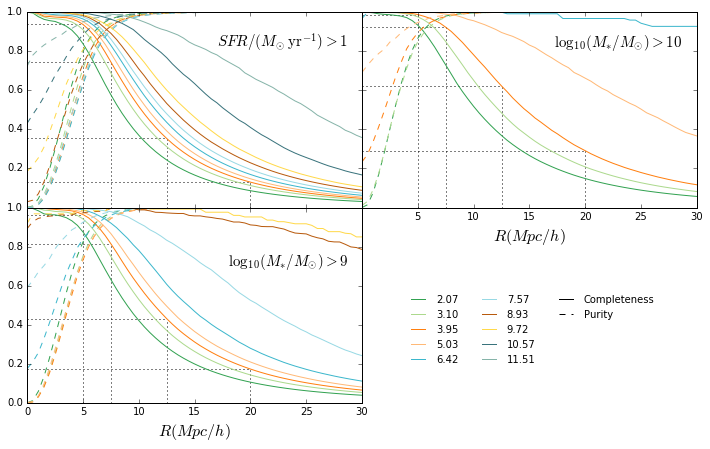

In [110]:
fig = plt.figure(figsize=(12,7))

gs = gridspec.GridSpec(2, 2)

gs.update(hspace=0, wspace=0) #bottom = 0.57, top = 1, 

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[0,1])

rangex = [float(x)/2 for x in range(61)]

redshifts = ['2.07','3.10','3.95','5.03','6.42','7.57','8.93', '9.72', '10.57', '11.51']

for i, cstat in enumerate([cstats_z2p07_sfr, cstats_z3p10_sfr, cstats_z3p95_sfr, cstats_z5p03_sfr, cstats_z6p42_sfr, 
                           cstats_z7p57_sfr, cstats_z8p93_sfr, cstats_z9p72_sfr, cstats_z10p57_sfr, cstats_z11p51_sfr]):
    
#     ax1.fill_between(rangex, cstat['completeness_percentiles'][:,0], 
#                      cstat['completeness_percentiles'][:,1], alpha=0.07, color=cmap[i])
    
#     ax1.fill_between(rangex, cstat['purity_percentiles'][:,0], 
#                      cstat['purity_percentiles'][:,1], alpha=0.07, color=cmap[i])

    ax1.plot(rangex, np.mean([x[0] for x in cstat['cstats']], axis=0), c=cmap[i], linestyle='dashed')
    

    ax1.plot(rangex,np.ma.masked_where([x[1] for x in cstat['cstats'] if x[1]] == 0, 
                   np.mean([x[1] for x in cstat['cstats'] if x[1]], axis=0)), c=cmap[i])


ax1.vlines([5,7.5,12.5,20], [0,0,0,0], np.mean([x[1] for x in cstats_z3p95_sfr['cstats']], axis=0)[[10, 15, 25, 40]], linestyle='dotted')
ax1.hlines(np.mean([x[1] for x in cstats_z3p95_sfr['cstats']], axis=0)[[10, 15, 25, 40]], [0,0,0,0], [5,7.5,12.5,20], linestyle='dotted')

ax1.set_xlabel('$R (Mpc / h)$', size=16)
ax1.set_xticklabels('')

line_z = []
for i in range(len(redshifts)):
    line_z.append(plt.Line2D((0,1),(0,0), color=cmap[i], linestyle='solid'))

line_space = plt.Line2D((0,1.5),(0,0), color='white', linestyle='solid', linewidth=1)

ax3.legend(handles=[line for line in line_z] + [line_comp, line_puri, line_space, line_space], 
               labels=[z for z in redshifts] + ['Completeness', 'Purity', '', ''],
               prop={'size':10}, bbox_to_anchor=(0.9, -0.4), ncol=3, frameon=False)

#### Plot 2

for i, (z, cstat) in enumerate(zip(redshifts, [cstats_z2p07_mstar9, cstats_z3p10_mstar9, cstats_z3p95_mstar9, cstats_z5p03_mstar9, cstats_z6p42_mstar9,
              cstats_z7p57_mstar9, cstats_z8p93_mstar9, cstats_z9p72_mstar9, cstats_z10p57_mstar9, cstats_z11p51_mstar9])):
    
#     ax2.fill_between(rangex, cstat['completeness_percentiles'][:,0], 
#                      cstat['completeness_percentiles'][:,1], alpha=0.08, color='grey')
    
#     ax2.fill_between(rangex, cstat['purity_percentiles'][:,0], 
#                      cstat['purity_percentiles'][:,1], alpha=0.08, color='grey')
    
    ax2.plot(rangex, np.mean([x[0] for x in cstat['cstats']], axis=0), c=cmap[i], linestyle='dashed')

    ax2.plot(rangex, np.ma.masked_where([x[1] for x in cstat['cstats'] if x[1]] == 0, 
                    np.vstack([x[1] for x in cstat['cstats'] if x[1]])).mean(axis=0), c=cmap[i], label=z)

ax2.vlines([5,7.5,12.5,20], [0,0,0,0], np.mean([x[1] for x in cstats_z3p95_mstar9['cstats']], axis=0)[[10, 15, 25, 40]], linestyle='dotted')
ax2.hlines(np.mean([x[1] for x in cstats_z3p95_mstar9['cstats']], axis=0)[[10, 15, 25, 40]], [0,0,0,0], [5,7.5,12.5,20], linestyle='dotted')


ax2.set_xlabel('$R (Mpc / h)$', size=16)
# ax2.set_xticklabels('')


#### Plot 3

for i, cstat in enumerate([cstats_z2p07_mstar10, cstats_z3p10_mstar10, cstats_z3p95_mstar10, cstats_z5p03_mstar10, cstats_z6p42_mstar10]):
#     ax3.fill_between(rangex, cstat['completeness_percentiles'][:,0], 
#                      cstat['completeness_percentiles'][:,1], alpha=0.1, color='grey')
    
#     ax3.fill_between(rangex, cstat['purity_percentiles'][:,0], 
#                      cstat['purity_percentiles'][:,1], alpha=0.1, color='grey')

    ax3.plot(rangex, np.mean([x[0] for x in cstat['cstats']], axis=0), c=cmap[i], linestyle='dashed')

    ax3.plot(rangex, np.ma.masked_where([x[1] for x in cstat['cstats'] if x[1]]==0, 
                    [x[1] for x in cstat['cstats'] if x[1]]).mean(axis=0), cmap[i])

ax3.vlines([5,7.5,12.5,20], [0,0,0,0], np.mean([x[1] for x in cstats_z3p95_mstar10['cstats']], axis=0)[[10, 15, 25, 40]], linestyle='dotted')
ax3.hlines(np.mean([x[1] for x in cstats_z3p95_mstar10['cstats']], axis=0)[[10, 15, 25, 40]], [0,0,0,0], [5,7.5,12.5,20], linestyle='dotted')


ax3.set_xlabel('$R (Mpc / h)$', size=16)
#ax3.set_ylabel('$f$', rotation=0, size=16)
ax3.set_yticklabels([])

ax3.set_xticklabels(['','5','10','15','20','25','30'])
ax1.set_yticklabels(['','0.2','0.4','0.6','0.8','1.0'])

ax1.text(17, 0.82, "$SFR / (M_{\odot} \; \mathrm{yr}^{-1}) > 1$", size=15, color='k')
ax2.text(18, 0.7, "$\mathrm{log_{10}}(M_{*} / M_{\odot}) > 9$", size=15, color='k')
ax3.text(17.2, 0.82, "$\mathrm{log_{10}}(M_{*} / M_{\odot}) > 10$", size=15, color='k')

# plt.savefig("../papers/hightolowz/images/compur.png", bbox_inches='tight', dpi=300)

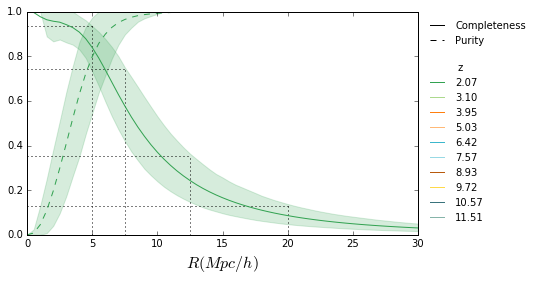

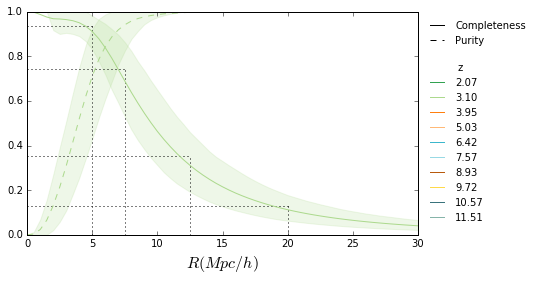

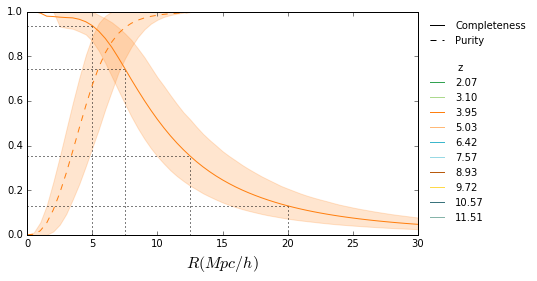

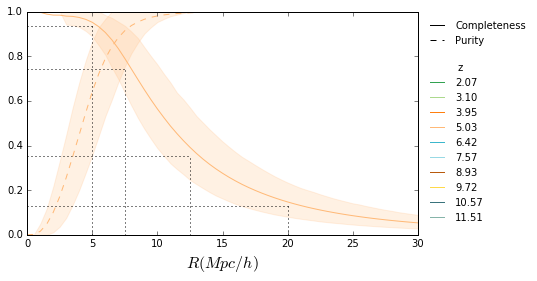

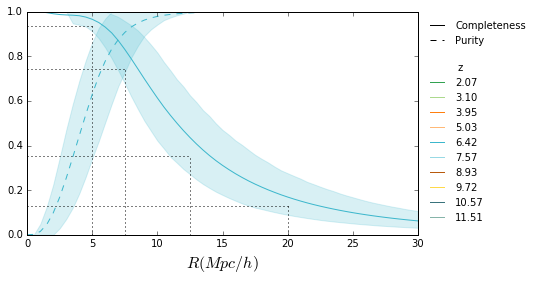

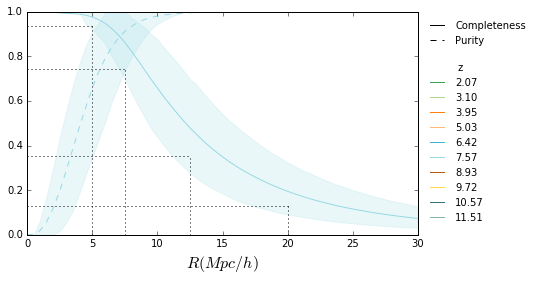

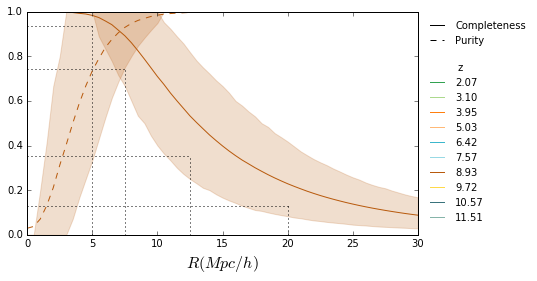

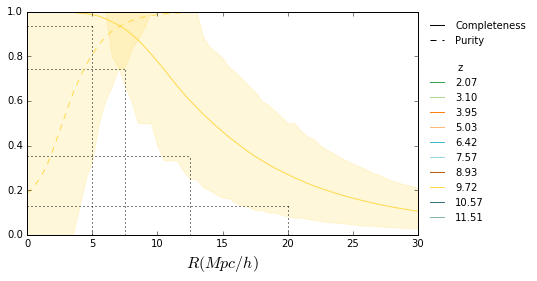

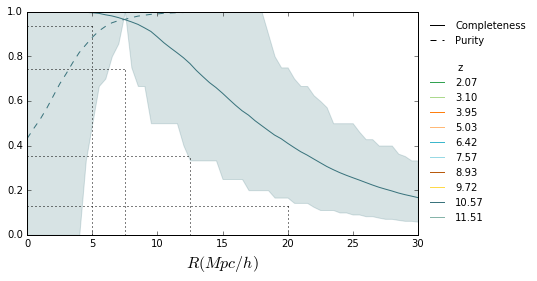

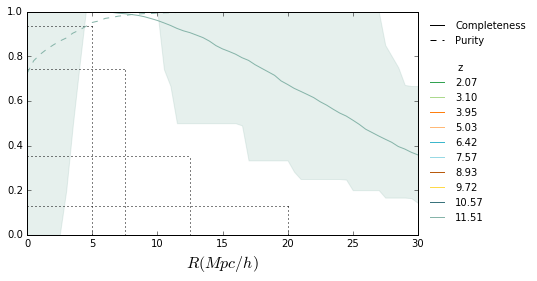

In [77]:
for j in range(10):

    fig = plt.figure(figsize=(7,4))

    rangex = [float(x)/2 for x in range(61)]

    redshifts = ['2.07','3.10','3.95','5.03','6.42','7.57','8.93', '9.72', '10.57', '11.51']

    for i, cstat in enumerate([cstats_z2p07_sfr, cstats_z3p10_sfr, cstats_z3p95_sfr, cstats_z5p03_sfr, cstats_z6p42_sfr, 
                               cstats_z7p57_sfr, cstats_z8p93_sfr, cstats_z9p72_sfr, cstats_z10p57_sfr, cstats_z11p51_sfr]):

        if i == j:

            plt.fill_between(rangex, cstat['completeness_percentiles'][:,0], 
                             cstat['completeness_percentiles'][:,1], alpha=0.2, color=cmap[i])

            plt.fill_between(rangex, cstat['purity_percentiles'][:,0], 
                             cstat['purity_percentiles'][:,1], alpha=0.2, color=cmap[i])

            plt.plot(rangex, np.mean([x[0] for x in cstat['cstats']], axis=0), c=cmap[i], linestyle='dashed')


            plt.plot(rangex,np.ma.masked_where([x[1] for x in cstat['cstats'] if x[1]] == 0, 
                           np.mean([x[1] for x in cstat['cstats'] if x[1]], axis=0)), c=cmap[i])


    plt.vlines([5,7.5,12.5,20], [0,0,0,0], np.mean([x[1] for x in cstats_z3p95_sfr['cstats']], axis=0)[[10, 15, 25, 40]], linestyle='dotted')
    plt.hlines(np.mean([x[1] for x in cstats_z3p95_sfr['cstats']], axis=0)[[10, 15, 25, 40]], [0,0,0,0], [5,7.5,12.5,20], linestyle='dotted')

    plt.xlabel('$R (Mpc / h)$', size=16)

    line_z = []
    for i in range(len(redshifts)):
        line_z.append(plt.Line2D((0,1),(0,0), color=cmap[i], linestyle='solid'))

    line_comp = plt.Line2D((0,1.5),(0,0), color='black', linestyle='solid', linewidth=1)
    line_puri = plt.Line2D((0,1.5),(0,0), color='black', linestyle='dashed', linewidth=1)

    line_space = plt.Line2D((0,1.5),(0,0), color='white', linestyle='solid', linewidth=1)

    plt.legend(handles=[line_comp, line_puri, line_space] + [line for line in line_z], 
               labels=['Completeness', 'Purity', '\n z'] + [z for z in redshifts],
               prop={'size':10}, frameon=False, bbox_to_anchor=(1.3, 1))

    plt.savefig("../papers/hightolowz/images/compur_single_%s.png" % j, bbox_inches='tight', dpi=300)